# Transfer Learning

**Transfer learning** is the process of extracting and using layers from a trained neural network architecture to create a new model. The previous model design is required to perform **transfer learning**, but computation time can be reduced if the weights from training are also available. 

----

## Retrieving Images & Performing Manipulations

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1/255.,
    rotation_range = 40,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

train_generator = train_datagen.flow_from_directory(
    'dataset/training_set',
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)

test_datagen = ImageDataGenerator( rescale = 1/255. )

test_generator = test_datagen.flow_from_directory(
    'dataset/test_set',
    batch_size = 20,
    class_mode = 'binary',
    target_size = (150, 150)
)

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


----

## Retrieving Weights

In [2]:
import urllib.request as req

url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
filename = 'inception_v3_weights.h5'
req.urlretrieve(url, filename)

('inception_v3_weights.h5', <http.client.HTTPMessage at 0x2122e92e748>)

----

## Instantiating the Previous Model

**InceptionV3** is a neural network architecture that was added to the Tensorflow library. It only contains the structure of the network, so the weights need to be added in. 

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

pre_model.load_weights(filename)

# The weights for the model are already provided and extra training isn't required.
for layer in pre_model.layers:
    layer.trainable = False
    
pre_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

----

## Creating the New Model

In [4]:
import tensorflow as tf

last_layer_output = pre_model.get_layer('mixed7').output

model = tf.keras.layers.Flatten()(last_layer_output)
model = tf.keras.layers.Dense(1024, activation = 'relu')(model)
# The dropout layer randomly removes nodes from the network.
# This prevents the nodes in the 1024-node Dense layer from simply copying the output from the Mixed lyer.
model = tf.keras.layers.Dropout(0.2)(model)
model = tf.keras.layers.Dense(1, activation = 'sigmoid')(model)
model = tf.keras.Model(pre_model.input, model)

model.compile(
    optimizer = tf.keras.optimizers.RMSprop(lr = 0.0001),
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

----

## Training the Model

In [8]:
results = model.fit(
    train_generator,
    validation_data = test_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_steps = 25,
    verbose = 2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 25 steps
Epoch 1/20
100/100 - 14s - loss: 0.2797 - accuracy: 0.8905 - val_loss: 0.3411 - val_accuracy: 0.9740
Epoch 2/20
100/100 - 14s - loss: 0.3044 - accuracy: 0.8795 - val_loss: 0.4159 - val_accuracy: 0.9640
Epoch 3/20
100/100 - 14s - loss: 0.2684 - accuracy: 0.8945 - val_loss: 0.4283 - val_accuracy: 0.9660
Epoch 4/20
100/100 - 14s - loss: 0.3082 - accuracy: 0.8885 - val_loss: 0.3370 - val_accuracy: 0.9720
Epoch 5/20
100/100 - 14s - loss: 0.2713 - accuracy: 0.8880 - val_loss: 0.3289 - val_accuracy: 0.9740
Epoch 6/20
100/100 - 14s - loss: 0.2896 - accuracy: 0.8815 - val_loss: 0.4206 - val_accuracy: 0.9660
Epoch 7/20
100/100 - 14s - loss: 0.2621 - accuracy: 0.8935 - val_loss: 0.4420 - val_accuracy: 0.9660
Epoch 8/20
100/100 - 14s - loss: 0.2564 - accuracy: 0.8950 - val_loss: 0.4330 - val_accuracy: 0.9640
Epoch 9/20
100/100 - 14s - loss: 0.2937 - accuracy: 0.8885 - val_loss: 0.3637 - val_accuracy: 0.972

----

## Plotting Accuracy & Loss

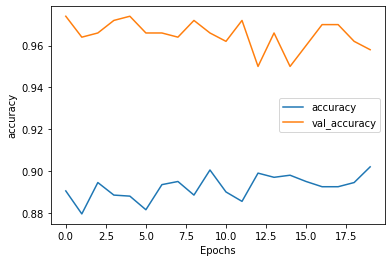

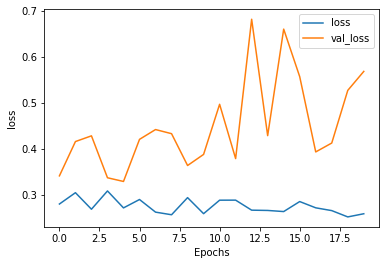

In [10]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history[string])
    plt.plot(history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

plot_graphs(results.history, "accuracy")
plot_graphs(results.history, "loss")